# **BDTs at work: the $\Omega$ analysis**

The goal of this tutorial is to provide an example of binary classification with machine learning techniques applied to an ALICE analysis. This tutorial is based on the measurement of the invariant mass of the $\mathrm{\Omega}$ , through its cascade decay channel $\mathrm{\Omega^-} \rightarrow \mathrm{\Lambda} + K^- \rightarrow p + \pi^- + K^-$. We will need two samples: 
- Real data: Pb--Pb collisions at $s_{\sqrt{NN}} = 5.02$ TeV (LHC18qr, subsample)
- Anchored MC production: LHC21l5

At the end of the tutorial we will be able to see the peak of the $\mathrm{\Omega}$ !


<img src="img/omega_dec.png" 
     align="center" 
     width="500" />

#### First, we need some libraries ###

In [9]:
### standard sci-py libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
import uproot ### to read, convert, inspect ROOT TTrees


One tip before starting: to access the documentation associated to each function we are going to call just type Shift+Tab after the first parenthesis of the function

## Reading trees with uproot, handling them with pandas

Uproot (https://github.com/scikit-hep/uproot4) is a Python package that provides tools for reading/writing ROOT files using Python and Numpy (does not depend on ROOT) and is primarly intended to stream data into machine learning libraries in Python.

In [10]:
## first we have to download the trees

# !curl -L https://cernbox.cern.ch/s/V05rgkoJfGe8x7K/download --output AnalysisResults-mc_reduced.root
# !curl -L https://cernbox.cern.ch/s/ReP4m9tDJ6UfivD/download --output AnalysisResults_reduced.root

In [11]:
mc_file = uproot.open("AnalysisResults-mc_reduced.root")

In [12]:
mc_file.keys()

['XiOmegaTree;10']

In [13]:
mc_file["XiOmegaTree"].keys()

['MiniCascadeMC',
 'MiniCascadeMC/MiniCascade',
 'MiniCascadeMC/MiniCascade/pt',
 'MiniCascadeMC/MiniCascade/eta',
 'MiniCascadeMC/MiniCascade/mass',
 'MiniCascadeMC/MiniCascade/ct',
 'MiniCascadeMC/MiniCascade/radius',
 'MiniCascadeMC/MiniCascade/radiusV0',
 'MiniCascadeMC/MiniCascade/dcaBachPV',
 'MiniCascadeMC/MiniCascade/dcaV0PV',
 'MiniCascadeMC/MiniCascade/dcaV0piPV',
 'MiniCascadeMC/MiniCascade/dcaV0prPV',
 'MiniCascadeMC/MiniCascade/dcaV0tracks',
 'MiniCascadeMC/MiniCascade/dcaBachV0',
 'MiniCascadeMC/MiniCascade/cosPA',
 'MiniCascadeMC/MiniCascade/cosPAV0',
 'MiniCascadeMC/MiniCascade/V0invMassDelta',
 'MiniCascadeMC/MiniCascade/tpcNsigmaBach',
 'MiniCascadeMC/MiniCascade/tpcNsigmaV0Pr',
 'MiniCascadeMC/MiniCascade/tpcNsigmaV0Pi',
 'MiniCascadeMC/MiniCascade/competingMass',
 'MiniCascadeMC/MiniCascade/bachBarCosPA',
 'MiniCascadeMC/MiniCascade/tpcClBach',
 'MiniCascadeMC/MiniCascade/tpcClV0Pr',
 'MiniCascadeMC/MiniCascade/tpcClV0Pi',
 'MiniCascadeMC/MiniCascade/centrality',
 '

In [14]:
## convert the tree into a dictionary of numpy arrays

In [15]:
numpy_mc = mc_file["XiOmegaTree"].arrays(library="np")

In [16]:
## print the array

Not easy to handle! Better to use Pandas. Pandas is a library that provides data structures and analysis tools for Pyhton. The two primary data structures of pandas are Series (1-dimensional) and DataFrame (2-dimensional) and we will work with them.
- Series are 1-dimensional ndarray with axis labels.
- DataFrames are 2-dimensional tabular data structure with labeled axes (rows and columns).

For more details: https://pandas.pydata.org/pandas-docs/stable/

In [17]:
## same exercise as before, but use pandas this time

In [18]:
pd_mc = mc_file["XiOmegaTree"].arrays(library="pd")

In [19]:
pd_mc['pdg']

0             0
1          3312
2         -3312
3             0
4          3312
           ... 
5522270    3334
5522271       0
5522272       0
5522273   -3312
5522274   -3334
Name: pdg, Length: 5522275, dtype: int32

In [20]:
pd_mc.columns ## the suffix MC indicates the generated quantity

Index(['pt', 'eta', 'mass', 'ct', 'radius', 'radiusV0', 'dcaBachPV', 'dcaV0PV',
       'dcaV0piPV', 'dcaV0prPV', 'dcaV0tracks', 'dcaBachV0', 'cosPA',
       'cosPAV0', 'V0invMassDelta', 'tpcNsigmaBach', 'tpcNsigmaV0Pr',
       'tpcNsigmaV0Pi', 'competingMass', 'bachBarCosPA', 'tpcClBach',
       'tpcClV0Pr', 'tpcClV0Pi', 'centrality', 'matter', 'hasTOFhit',
       'hasITSrefit', 'isOmega', 'ptMC', 'etaMC', 'ctMC', 'yMC', 'pdg',
       'isReconstructed', 'flag', 'index'],
      dtype='object')

#### Query and eval operations to apply selections and generate new columns

In [21]:
## let's focus only on Omegas
pd_mc.query("isOmega and abs(pdg)==3334", inplace=True)

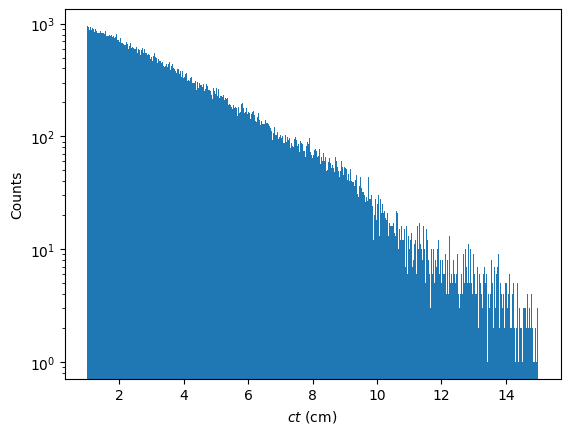

In [22]:
## have a look at the momentum and decay length generated distributions
plt.hist(pd_mc["ctMC"], bins=1000, range=[1,15]);
plt.yscale("log")
plt.xlabel(r"$ct$ (cm)");
plt.ylabel("Counts");

In [23]:
## select only the MC particles that are reconstructed, but keep the full df
df_reco = pd_mc.query("isReconstructed")

In [24]:
## compute the relative momentum resolution using eval

In [25]:
df_reco.eval("momRes = (pt - ptMC)/ptMC", inplace=True)

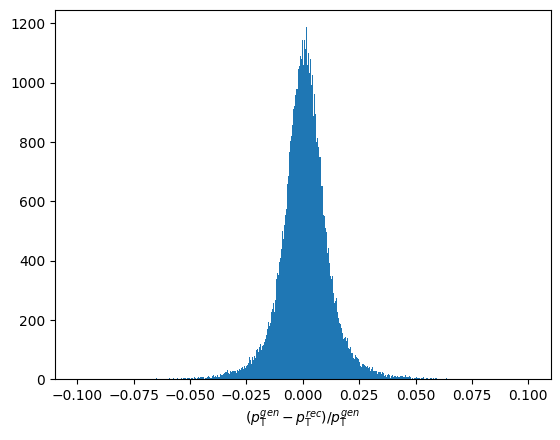

In [26]:
plt.hist(df_reco["momRes"], bins=800, range=[-0.1,0.1]);
plt.xlabel(r"$(p_{\mathrm{T}} ^{gen} - p_{\mathrm{T}} ^{rec}) / p_{\mathrm{T}} ^{gen}$");

In [27]:
## compute the efficiency vs momentum using numpy histograms

In [28]:
mc_gen_hist_numpy = np.histogram(pd_mc['ptMC'], bins=100, range=[1,5])
mc_rec_hist_numpy = np.histogram(df_reco['pt'], bins=100, range=[1,5])


In [29]:
bins = mc_gen_hist_numpy[1]
bin_centres = (bins[:-1] + bins[1:]) / 2

In [30]:
eff_vals = mc_rec_hist_numpy[0]/mc_gen_hist_numpy[0]

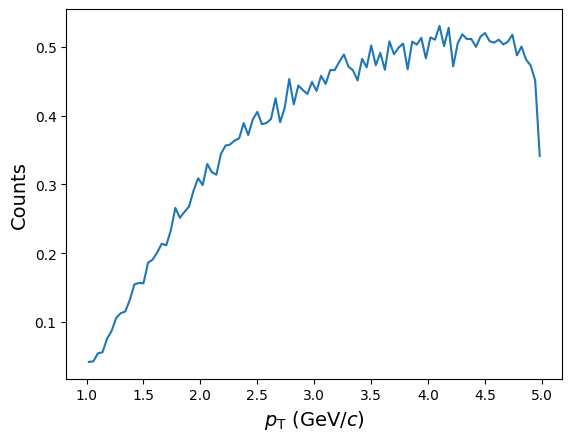

In [31]:
plt.plot(bin_centres, eff_vals);
plt.xlabel(r"$p_\mathrm{T}$ (GeV/$c$)", fontsize=14);
plt.ylabel(r"Counts", fontsize=14);

## Machine Learning

Supervised learning is a subcategory of ML well known in HEP. Supervised learning
algorithms are employed for discriminating between two or more classes, signal and
background in our case, starting from a set of examples called training set. Each
element of the training sample, a $\Omega$ candidate in this tutorial, has a label
containing its class (signal / background), which is known a priori: the training
process fixes the internal parameters of the learning algorithm in order to maximize
the separation power among the classes. The goal of the training is to teach to the model a common pattern in data that can be used to classify properly an independent sample, in our case the real data sample. The output of the supervised model, or score, is evaluated starting from the candidate properties, which are called features. The score is related to the candidate probability of belonging to the different classes


In this tutorial Boosted Decision Trees (BDTs) will be used for tagging real $\Omega$ candidates. The core of every BDT model is the decision tree algorithm (DT). A
DT is a flowchart-like binary structure where an internal node represents a feature(or
candidate), the branch represents a decision rule, and each leaf node represents the
outcome. The topmost node in a decision tree is known as the root node. The DT
works by combining a sequence of simple binary tests (each branch of the tree), to
classify a data point in terms of its features. Each test consists in a linear threshold
applied to one of the features which helps the model to predict the belonging class
of every candidate. 

<img src="img/Titanic_Survival_Decison_Tree_SVG.png" 
     align="center" 
     width="400" />


The training of a DT consists in the automatic procedure that builds the tree recursively starting from the training set. The main flaw of the DT is that it is prone to the so-called overfitting: this means that the model is able to perfectly classify the training set if deep enough (the depth
is defined as the length of the longest path from a root to a leaf), but it does not generalize well to new data. Overfitting occurs when the model memorizes the training
set rather than learning a general pattern in the data. To overcome this problem,
BDT algorithms combine numerous shallow trees using for each a subsample of
features. In particular, in the boosting procedure the DTs are constructed sequentially
taking care of compensating the misclassified candidates of the previous trees. The
resulting model, the BDT, maintains high performances both on the training and the
test set.

<img src="img/xgb_score.png" 
     align="center" 
     width="400" />




First we will import hipe4ml: https://github.com/hipe4ml/hipe4ml

This is a package developed in ALICE containing useful methods and classes for dealing with ML analyses. Two main classes are implemented:
- TreeHandler, wrapping uproot and pandas methods: allows for conversion and handling of the training samples
- ModelHandler, a common interface for many ML methods

In [32]:
from hipe4ml.model_handler import ModelHandler
from hipe4ml.tree_handler import TreeHandler
from hipe4ml import analysis_utils
from hipe4ml import plot_utils

In [33]:
### Read TTrees with hipe4ml

In [34]:
hdl_mc = TreeHandler("AnalysisResults-mc_reduced.root", "XiOmegaTree")
hdl_data = TreeHandler("AnalysisResults_reduced.root", "XiOmegaTree")

In [64]:
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters)

In [67]:
file = uproot.open('AnalysisResults-mc_reduced.root')
tree=file.get('XiOmegaTree')
tree.keys()


['MiniCascadeMC',
 'MiniCascadeMC/MiniCascade',
 'MiniCascadeMC/MiniCascade/pt',
 'MiniCascadeMC/MiniCascade/eta',
 'MiniCascadeMC/MiniCascade/mass',
 'MiniCascadeMC/MiniCascade/ct',
 'MiniCascadeMC/MiniCascade/radius',
 'MiniCascadeMC/MiniCascade/radiusV0',
 'MiniCascadeMC/MiniCascade/dcaBachPV',
 'MiniCascadeMC/MiniCascade/dcaV0PV',
 'MiniCascadeMC/MiniCascade/dcaV0piPV',
 'MiniCascadeMC/MiniCascade/dcaV0prPV',
 'MiniCascadeMC/MiniCascade/dcaV0tracks',
 'MiniCascadeMC/MiniCascade/dcaBachV0',
 'MiniCascadeMC/MiniCascade/cosPA',
 'MiniCascadeMC/MiniCascade/cosPAV0',
 'MiniCascadeMC/MiniCascade/V0invMassDelta',
 'MiniCascadeMC/MiniCascade/tpcNsigmaBach',
 'MiniCascadeMC/MiniCascade/tpcNsigmaV0Pr',
 'MiniCascadeMC/MiniCascade/tpcNsigmaV0Pi',
 'MiniCascadeMC/MiniCascade/competingMass',
 'MiniCascadeMC/MiniCascade/bachBarCosPA',
 'MiniCascadeMC/MiniCascade/tpcClBach',
 'MiniCascadeMC/MiniCascade/tpcClV0Pr',
 'MiniCascadeMC/MiniCascade/tpcClV0Pi',
 'MiniCascadeMC/MiniCascade/centrality',
 '

In [27]:
### select only reconstructed MC Omega candidates: they will be our signal sample for the training
hdl_mc.apply_preselections("abs(pdg)==3334 and isOmega==1 and isReconstructed==1") 

In [28]:
hdl_mc.print_summary()


File name:  ['AnalysisResults-mc_reduced.root']
Tree name:  XiOmegaTree
DataFrame head:
            pt       eta      mass        ct    radius   radiusV0  dcaBachPV   
19   3.718178 -0.191665  1.670407  3.886258  8.334375  25.400000   1.012031  \
35   5.022789 -0.051110  1.673144  0.626525  2.282031  25.400000   0.198437   
82   2.387853  0.323383  1.674151  3.005663  3.869531   7.739062   0.218281   
131  2.701713  0.547879  1.672960  5.710333  9.326562  25.400000   1.766094   
164  2.563023  0.532789  1.671649  2.535935  4.266406  20.141406   0.099219   

      dcaV0PV  dcaV0piPV  dcaV0prPV  ...  hasITSrefit  isOmega      ptMC   
19   0.515938   2.540000   0.625078  ...         True     True  3.803827  \
35   0.188516   2.540000   1.051719  ...         True     True  4.980243   
82   0.585391   2.222500   0.287734  ...         True     True  2.385551   
131  0.763984   2.540000   1.061641  ...         True     True  2.677118   
164  0.178594   1.686719   0.595313  ...         True  

In [29]:
### How to select the background? We can take it from the candidates available in
### the sidebands of our real data sample! 

In [30]:
hdl_bkg = hdl_data.apply_preselections("mass < 1.660 or mass > 1.685", inplace=False)
# hdl_bkg = hdl_data.apply_preselections("mass < 1.308 or mass > 1.334", inplace=False)

In [31]:
print(len(hdl_bkg), len(hdl_mc))

1996717 93957


The bkg data sample is much larger than the signal one. This does not represent a problem, as the BDT is not sensitive to the relative abundances of the classes. However, to speed-up the training process, only a 20% fraction of the background will be
used for the training

In [32]:
hdl_bkg.shuffle_data_frame(frac=0.20, inplace=True)

In [33]:
## now we remove the background from the data sample
hdl_data.apply_preselections("mass > 1.660 and mass < 1.685", inplace=True)

Data prepared! Now, before the training, we need to visualize the feature properties.
hipe4ml plot utilities allow for
- comparing the features of different samples (plot_distr)
- evaluate the correlations among the features

In [34]:
cols_to_be_compared = ['pt', 'ct', 'mass', 'dcaBachPV', 'dcaV0PV', 'dcaV0piPV', 'dcaV0prPV', 'dcaV0tracks', 
                 'dcaBachV0','cosPA', 'cosPAV0', 'tpcNsigmaV0Pr']

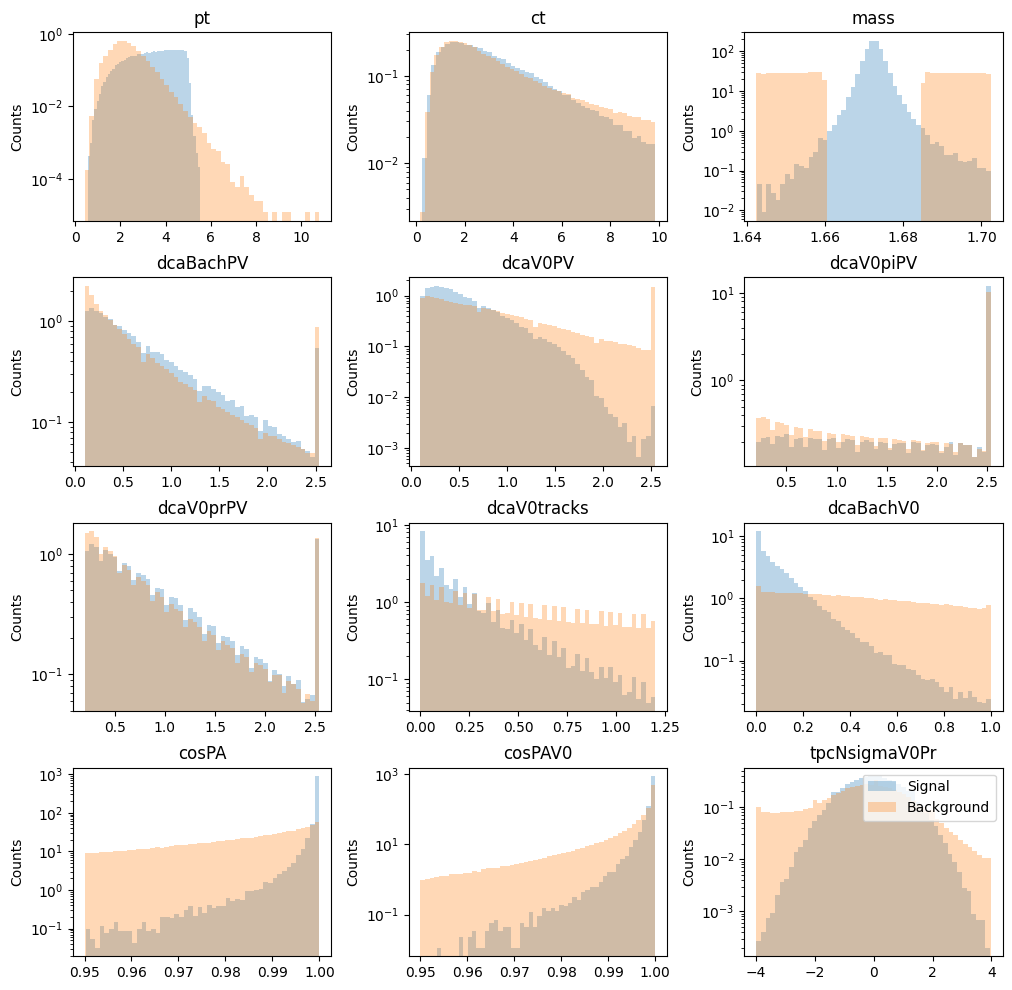

In [35]:
## some matplotlib tuning is needed to display all the features
plot_utils.plot_distr([hdl_mc, hdl_bkg], cols_to_be_compared, 
                      bins=50, labels=['Signal', 'Background'],
                      log=True, density=True, figsize=(12, 12), alpha=0.3, grid=False);

#### Some questions....
- Which variables do we expect to be relevant for the training? Can we use all of them? Pros  and cons?
- why do we see some spikes in the DCA?

And correlations are important as well: the model can potentially exploit them to perform a better classification. Moreover, there could be some potentially dangerous correlations as those with the invariant mass of the particle of interest

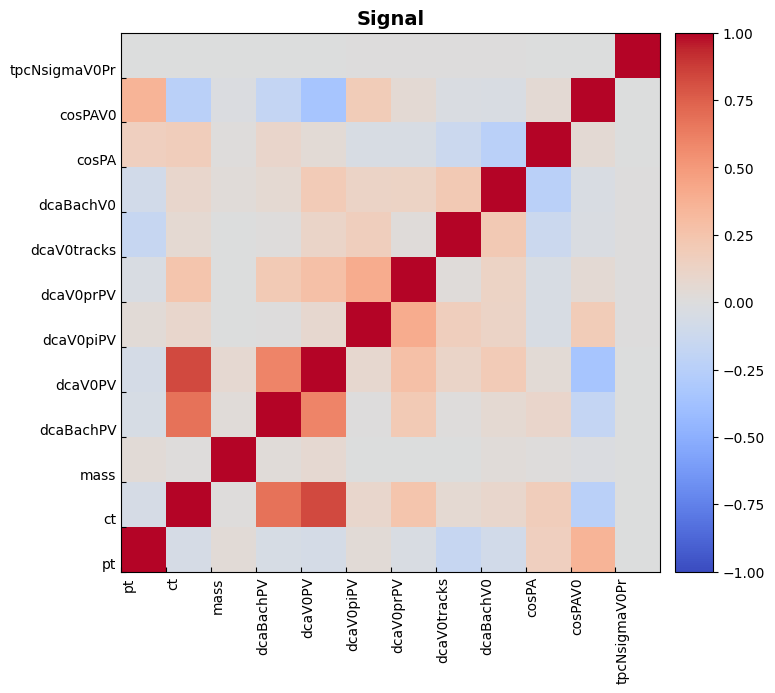

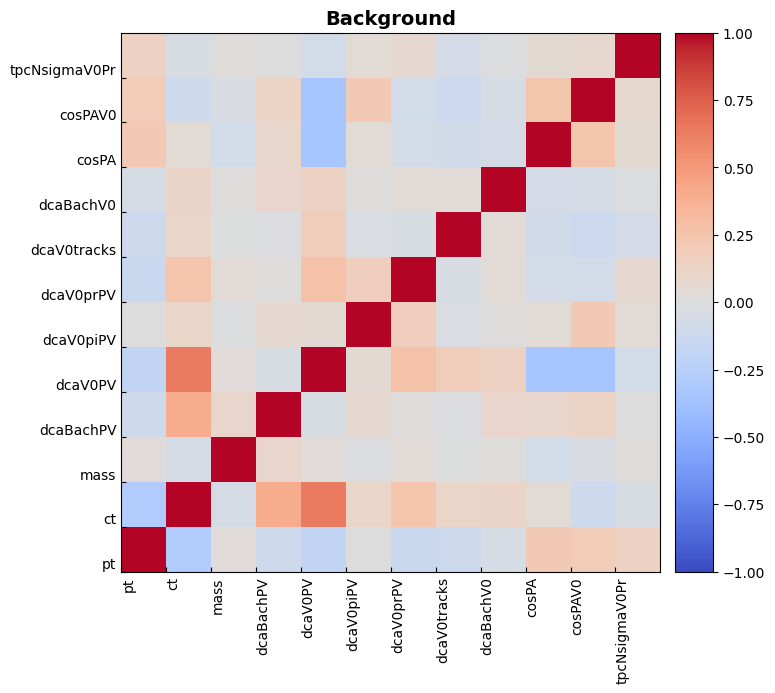

In [36]:
plot_utils.plot_corr([hdl_mc, hdl_bkg], cols_to_be_compared, labels=['Signal', 'Background']);

Considerations? Doubts? Let's now define the training columns and build the training sample

In [37]:
training_cols = ['dcaBachPV', 'dcaV0PV', 'dcaV0piPV', 'dcaV0prPV', 'dcaV0tracks', 
                 'dcaBachV0','cosPA', 'cosPAV0', 'tpcNsigmaV0Pr']

Now we split our data in a training and test set. To do it, we use the train_test_generator function from hipe4ml

In [38]:
train_test_data = analysis_utils.train_test_generator([hdl_bkg, hdl_mc], [0, 1], test_size=0.5, random_state=42)

## Training and testing a BDT

We will use the BDT of XGBoost (https://github.com/dmlc/xgboost): boosting is implemented with a gradient descent method. It features few hyperparameters that can be tuned to improve the performance and reduce the overfitting, even if the algorithm works smoothly out of the box.



In [39]:
import xgboost as xgb

In [40]:
n_estimators=276
max_depth=6
learning_rate=0.03

xgb_model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)

In [41]:
model_hdl = ModelHandler(xgb_model, training_cols)

## Optimize the model on the provided data

from optuna.samplers import RandomSampler

N_JOBS=8

hyper_pars_ranges = {'n_estimators': (20, 300), 'max_depth': (2, 6), 'learning_rate': (0.01, 0.1)}
rnd_study = model_hdl.optimize_params_optuna(train_test_data, hyper_pars_ranges, cross_val_scoring='roc_auc',
                                             timeout=60, n_jobs=N_JOBS, n_trials=20, direction='maximize',
                                             optuna_sampler=RandomSampler())

In [42]:
from optuna.samplers import RandomSampler

N_JOBS=8

hyper_pars_ranges = {'n_estimators': (20, 300), 'max_depth': (2, 12), 'learning_rate': (0.01, 0.1)}
rnd_study = model_hdl.optimize_params_optuna(train_test_data, hyper_pars_ranges, cross_val_scoring='roc_auc',
                                             timeout=60, n_jobs=N_JOBS, n_trials=20, direction='maximize',
                                             optuna_sampler=RandomSampler())

[I 2023-07-17 15:11:45,923] A new study created in memory with name: no-name-6ec787a5-d346-414f-919a-0a34a57a4a53
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0.

Number of finished trials: 8
Best trial:
Value: 0.984186843307741
Params: 
    n_estimators: 193
    max_depth: 6
    learning_rate: 0.08700607936040645


In [43]:
# tpe_time = time.time() - start
trials_rnd = rnd_study.trials
trials_array_tpe = np.array([t.values[0] for t in trials_rnd])

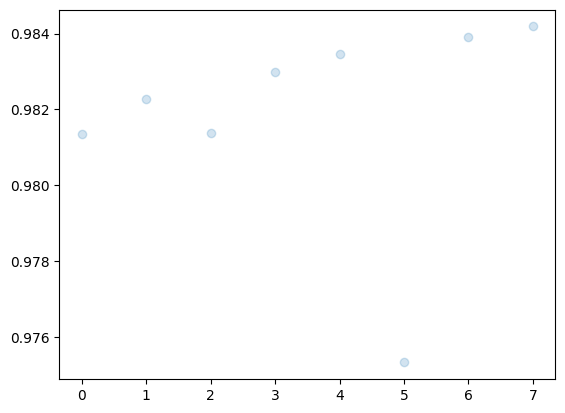

In [44]:
plt.plot(trials_array_tpe, 'o',
         label='TPEsampler', alpha=0.2)
# plt.plot(x_axis_ma, tpe_ma, label='TPESampler MA', color='blue')

## train_test_data[0] -> data for training
## train_test_data[2] -> data for testing


In [45]:
model_hdl.fit(train_test_data[0], train_test_data[1])

Training Done! Let's apply the model to the test sample

In [46]:
score_test = model_hdl.predict(train_test_data[2])

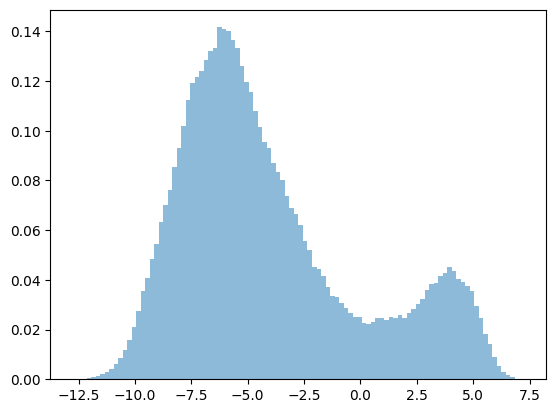

In [47]:
#### plot the score distribution
plt.hist(score_test, bins=100, label='full sample', alpha=0.5, density=True);

Two peaks clearly distinguishable: will they be corresponding to the signal and the background? Let's plot the two distribution separately

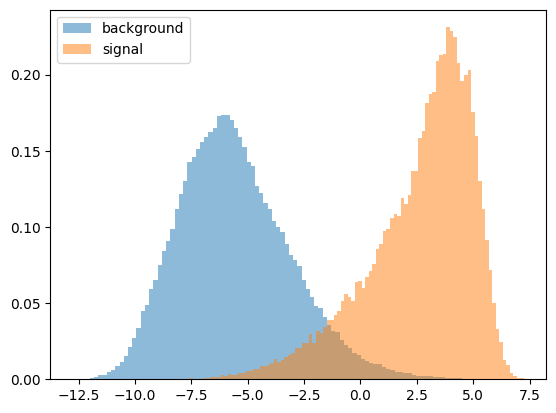

In [48]:
plt.hist(score_test[train_test_data[3]==0], bins=100, label='background', alpha=0.5, density=True);
plt.hist(score_test[train_test_data[3]==1], bins=100, label='signal', alpha=0.5, density=True);
plt.legend();


Well separated peaks on the test set! This is what we want.
Now we can evaluate the performance on the test set: we can use the ROC curve, which is built by plotting
the true positive rate (TPR) against the false negative rate (FPR) as a function of the
score threshold, where TPR and FPR are defined as:


$TPR=\frac{\sum TP}{\sum TP + \sum FN} \hspace{2cm} FPR=\frac{\sum FP}{\sum FP + \sum TN} $

and in our case represent the signal selection and the background rejection
efficiencies respectively as a function of the score. The most common way employed to evaluate the performance of a BDT is to
compute the area under the ROC curve, called AUC: a perfect classifier will have
a ROC AUC equal to 1, whereas a random classifier will have a ROC AUC equal
to 0.5.



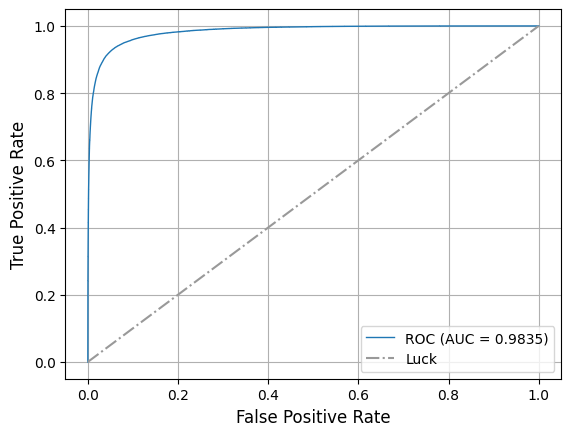

In [49]:
plot_utils.plot_roc(train_test_data[3], score_test);

Repeat this exercise with the training set: what do you get?

In [50]:
score_train = model_hdl.predict(train_test_data[0])

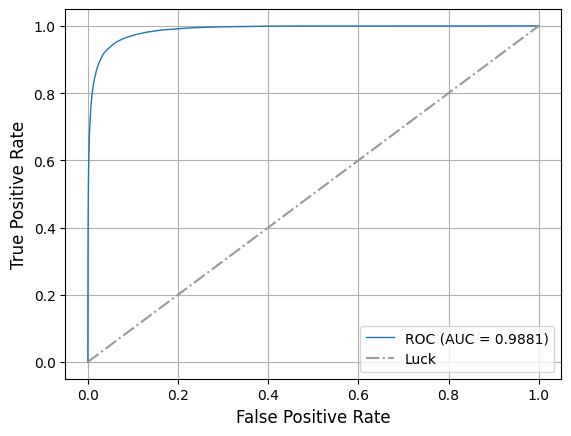

In [51]:
plot_utils.plot_roc(train_test_data[1], score_train);

Training ROC-AUC is slightly higher than the test set one. This is a systematic behaviour due to the small presence of overfitting. We can see it also by plotting the BDT output for the training and test set distributions

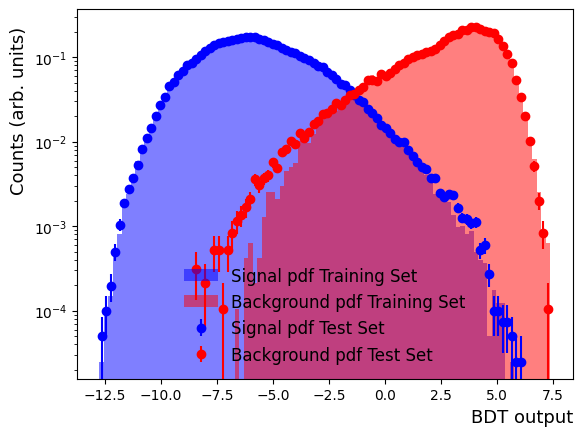

In [52]:
plot_utils.plot_output_train_test(model_hdl, train_test_data, density=True, bins=100, logscale=True);

Now, before applying the BDT to data we can have a look at which variables are relevant for the training. We will use the feature importance implemented in the SHAP library (https://github.com/slundberg/shap). In the context of machine learning, the Shapley value is used to evaluate the contribution of each feature to the model output, and it is calculated by averaging the marginal contributions of each feature to the model output. The marginal contribution of a feature is the difference in the model output when the feature is present or absent. The variables that are
more important for the model are those that have a higher marginal contribution, and Shapley values consequently.

In hipe4ml the function plot_feat_imp implements the algorithm: try to use it!

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


[<Figure size 1800x900 with 2 Axes>, <Figure size 1800x900 with 1 Axes>]

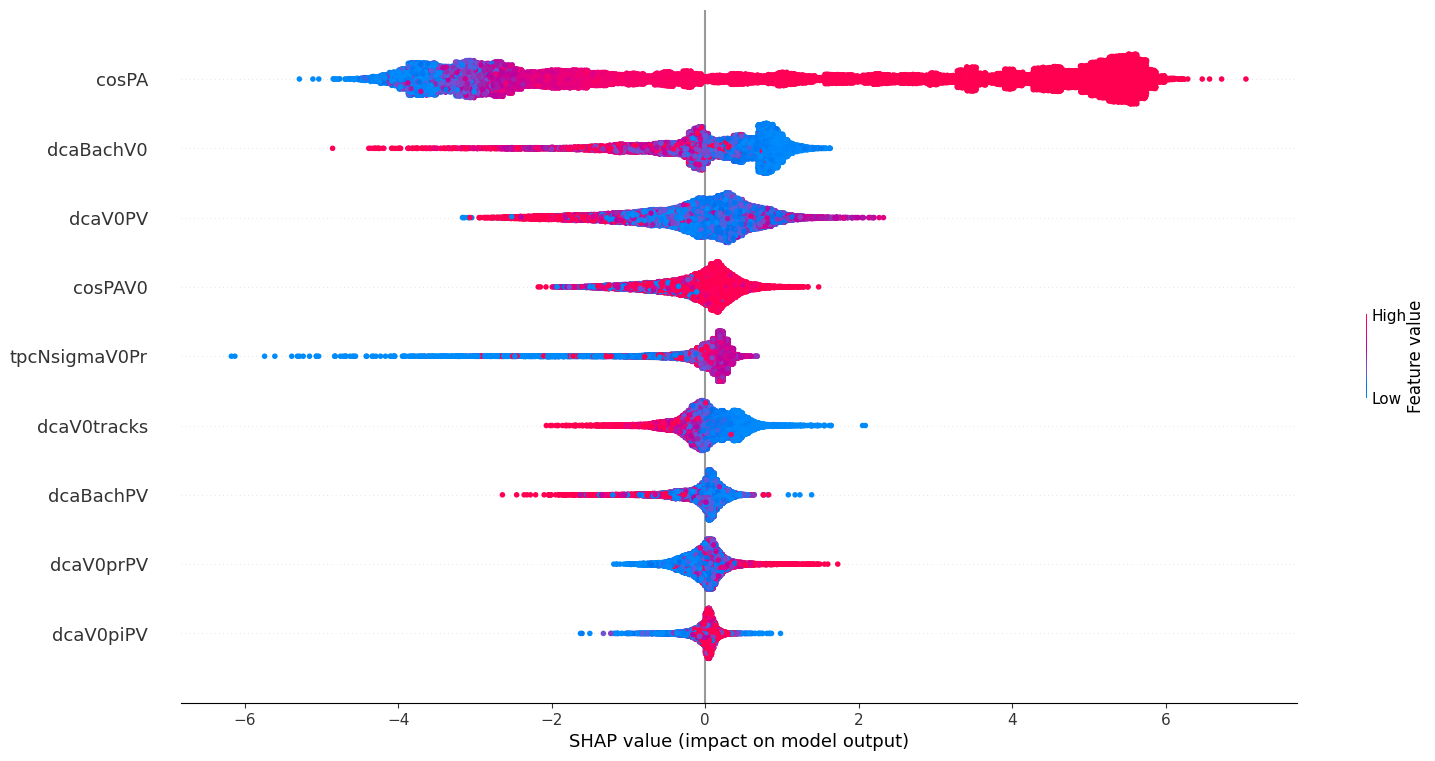

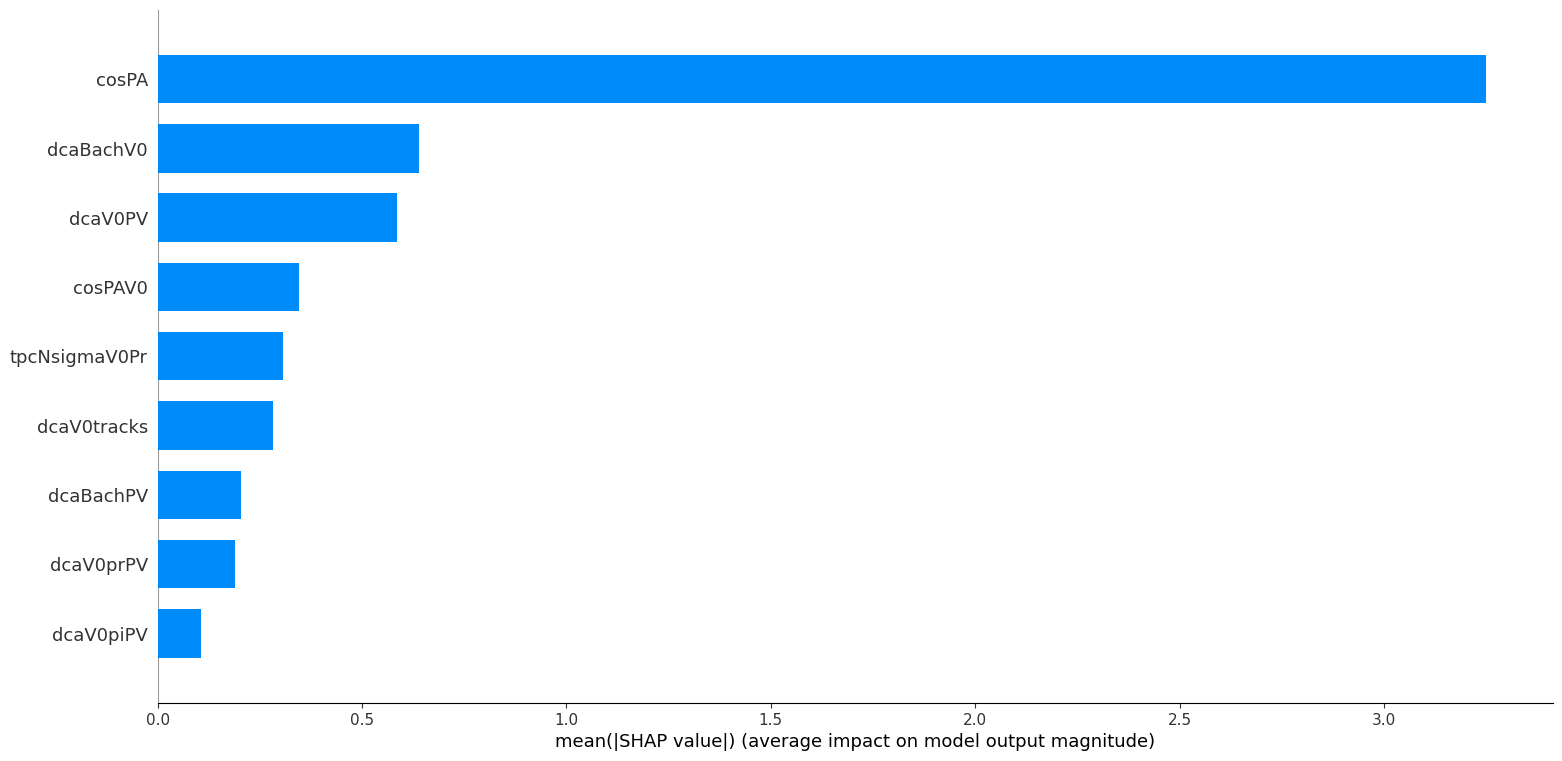

In [53]:
plot_utils.plot_feature_imp(train_test_data[2], train_test_data[3], model_hdl) 

Two plots given: how to interpret them?

**Bonus** : repeat the training using a different model and compare its performance with the XGB BDT. All the sklearn and keras (NN) models can be used to feed the ModelHandler

### Applying the BDT

Now that the model is tested we can use it to classify the real data sample. Try to evaluate the invariant mass as a function of the score distribution

In [54]:
hdl_data.apply_model_handler(model_hdl)

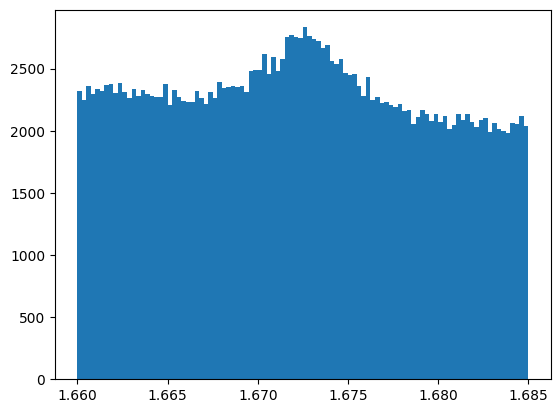

In [55]:
plt.hist(hdl_data.apply_preselections("model_output>-3", inplace=False)["mass"], bins=100);

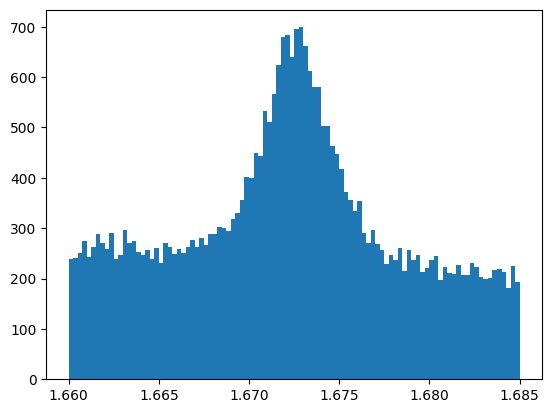

In [56]:
plt.hist(hdl_data.apply_preselections("model_output>0.5", inplace=False)["mass"], bins=100);

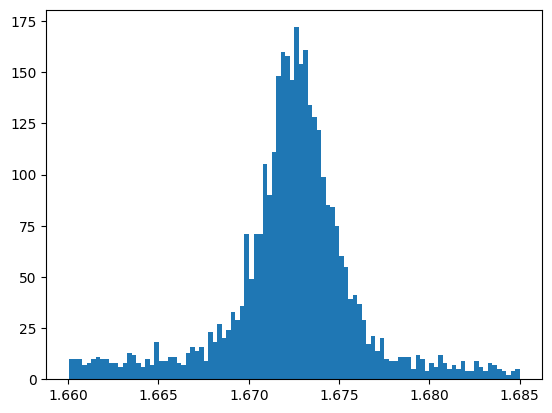

In [57]:
plt.hist(hdl_data.apply_preselections("model_output>4", inplace=False)["mass"], bins=100);

In [58]:
### very nice! But how to decide which threshold is the best one? Many methods can be used, but it is important to evaluate the selection efficiency
### as a function of the score. Excercise: write a function for computing the BDT efficiency vs Score. Would you compute it on the training or the test sets?

In [59]:
### hipe4ml has a function to do that! 
eff_array, score_array = analysis_utils.bdt_efficiency_array(train_test_data[3], score_test, 1000)

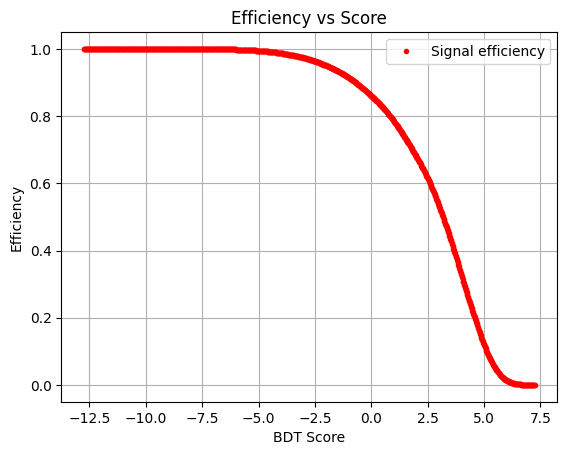

In [60]:
plot_utils.plot_bdt_eff(score_array, eff_array);

In [61]:
## Now we can try to fit the invariant mass spectrum

In [62]:
from scipy.optimize import curve_fit
from scipy import integrate

def fit_invmass(df, fit_range=[1.660, 1.685]):
    
    # histogram of the data
    counts, bins = np.histogram(df, bins=40, range=fit_range)
    
    # define functions for fitting    
    def gaus_function(x, N, mu, sigma):
        return N * np.exp(-(x-mu)**2/(2*sigma**2))
    
    def pol2_function(x, a, b):
        return (a + x*b)
    
    def fit_function(x, a, b, N, mu, sigma):
        return pol2_function(x, a, b) + gaus_function(x, N, mu, sigma)
    
    # x axis ranges for plots
    x_point = 0.5 * (bins[1:] + bins[:-1])
    r = np.arange(fit_range[0], fit_range[1], 0.00001)
    
    # fit the invariant mass distribution with fit_function() pol2+gauss
    popt, pcov = curve_fit(fit_function, x_point, counts, p0 = [100, -1, 100, 1.673, 0.001])
    
    # plot data
    plt.errorbar(x_point, counts, yerr=np.sqrt(counts), fmt='.', ecolor='k', color='k', elinewidth=1., label='Data')
    
    # plot pol2 and gauss obtained in the fit separately
    plt.plot(r, gaus_function(r, N=popt[2], mu=popt[3], sigma=popt[4]), label='Gaus', color='red')
    plt.plot(r, pol2_function(r, a=popt[0], b=popt[1]), label='pol2', color='green', linestyle='--')

    # plot the global fit
    plt.plot(r, fit_function(r, *popt), label='pol2+Gaus', color='blue')
    
    # compute significance of the signal
    signal = integrate.quad(gaus_function, fit_range[0], fit_range[1], args=(popt[2], popt[3], popt[4]))[0] / 0.00225
    background = integrate.quad(pol2_function, fit_range[0], fit_range[1], args=(popt[0], popt[1]))[0] / 0.00225
    print(f'Signal counts: {signal:.0f}')
    print(f'Background counts: {background:.0f}')     
    significance = signal / np.sqrt(signal + background)

    # Add some axis labels
    plt.legend()
    plt.xlabel('$M_{\Lambda\pi}$ $(\mathrm{GeV/}\it{c}^2)$')
    plt.ylabel('Counts')
    plt.show()


Signal counts: 708
Background counts: 254


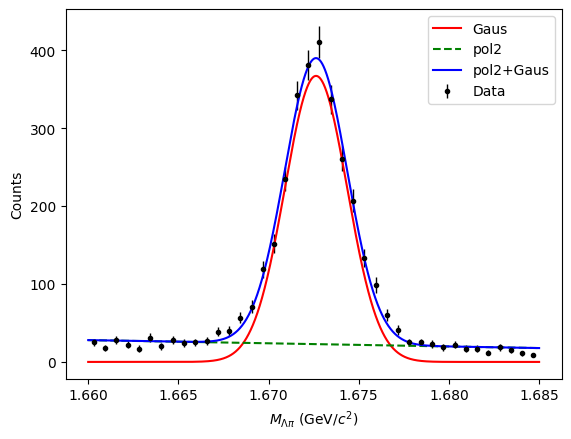

In [63]:
fit_invmass(hdl_data.apply_preselections("model_output>4", inplace=False)["mass"], fit_range=[1.660, 1.685])

In [64]:
### you can also use some packages for implementing ROOT like plots in python
import mplhep as hep
hep.style.use(hep.style.ROOT)

Signal counts: 2210
Background counts: 6698


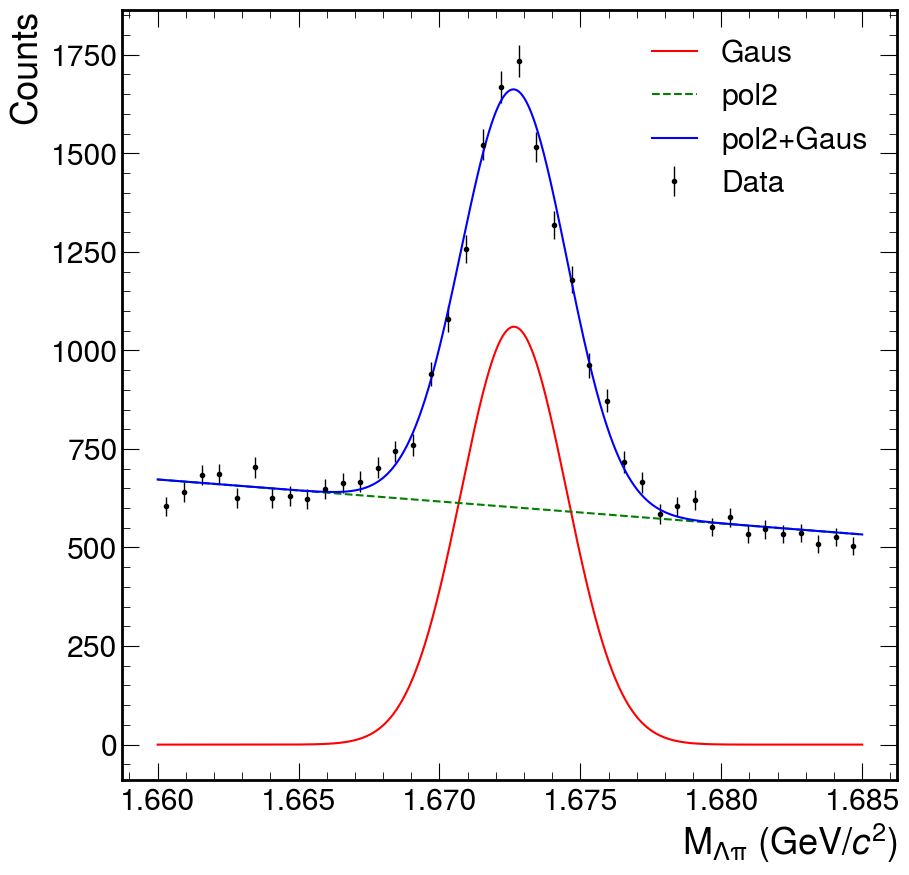

In [65]:
fit_invmass(hdl_data.apply_preselections("model_output>0.5", inplace=False)["mass"], fit_range=[1.660, 1.685])

In [66]:
#### reset matplotlib style if needed
plt.style.use('default')

For a dedicated fitting routine you can have a look at:
- https://github.com/flarefly/flarefly

### **Bonus**:  Repeat the excercise with the Xi

### **Bonus**: optimize your BDT

The XGBoost Classifier has many hyperparameters that control the complexity of
the model. Few of them are listed here, for a complete description see : https://xgboost.readthedocs.io/en/stable/parameter.html

- n_estimators: Number of trees in the BDT
- max_depth: Maximum depth of a tree
- eta: learning rate of the algorithm. It controls the step size of the gradient descent algorithm


The optimisation of the hyperparameters is a key step to obtain the best performance from the algorithm and prevent overfitting. In hipe4ml the Optuna package is employed for the optimisation through the method ModelHandler.optimize_params_optuna. (https://github.com/optuna/optuna)

The Optuna package provides a wide choice of algorithms for the hyperparameter optimization. The default one is the TPESampler, which is known to provide robust performance in few iterations. The difference between other approaches, like grid search or random search, and the TPESampler optimisation is that the latter takes into account past evaluations when choosing the hyperparameter set to evaluate next.

A set of hyperparameters should be tested on different samples to avoid overfitting problems. Since the number of events is limited, an approach called cross validation is used. It has been proved that the cross validation removes the dependence of the model on the data sample.

In the cross validation procedure, the original sample is divided in n parts called folds (in this case 5 folds are used). For each set of hyperparameters, n-1 folds are used for the optimisation and the remaining one as test. This operation is repeated after permuting the folds used for optimisation and for testing and the final result is the mean value of all the permutations.

The ModelHandler automatically updates the hyperparameters after their optimisation.

In [67]:
### Excercise: try to optimize your hyperparams with optuna and compare the performance! Be aware: the optimisation is CPU expensive and take some time

In [68]:
from optuna.samplers import RandomSampler


N_JOBS=8

hyper_pars_ranges = {'n_estimators': (20, 300), 'max_depth': (2, 6), 'learning_rate': (0.01, 0.1)}
rnd_study = model_hdl.optimize_params_optuna(train_test_data, hyper_pars_ranges, cross_val_scoring='roc_auc',
                                             timeout=60, n_jobs=N_JOBS, n_trials=20, direction='maximize',
                                             optuna_sampler=RandomSampler())

[I 2023-07-17 15:23:10,614] A new study created in memory with name: no-name-e83b8f0f-3553-4828-8780-2a8a9d4701de
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2023-07-17 15:24:55,151] Trial 7 finished with value: 0.9750391627142083 and parameters: {'n_estimators': 46, 'max_depth': 3, 'learning_rate': 0.04618117088303157}. Best is trial 7 with value: 0.9750391627142083.
[I 2023-07-17 15:25:23,848] Trial 5 finished with value: 0.9762437366833755 and parameters: {'n_estimators': 40, 'max_depth': 4, 'learning_rate': 0.029745859300494462}. Best is trial 5 with value: 0.9762437366833755.
[I 2023-07-17 15:27:24,058] Trial 6 finished with value: 0.9814279635573676 and parameters: {'n_estimators': 210, 'max_depth': 2, 'learning_rate': 0.08303658963084214}. Best is trial 6 with value: 0.9814279635573676.
[I 2023-07-17 15:27:46,254] Trial 1 

Number of finished trials: 8
Best trial:
Value: 0.9842394992807367
Params: 
    n_estimators: 296
    max_depth: 6
    learning_rate: 0.09388014368171074


In [69]:
rnd_time = time.time() - start
trials_rnd = rnd_study.trials
trials_array_rnd = np.array([t.values[0] for t in trials_rnd])

NameError: name 'time' is not defined